# Question 3 - [40 marks] <a class="tocSkip"></a>

We will study a population model with $n$ communities in which each community exchanges a percentage of its members with a number of neighbouring communities. The communities all have an $(x, y)$ location on the map and only exchange their population with neighbouring communities within a certain distance. For simplicity we will use the unit square, i.e. $0\leq x \leq 1$ and $0\leq y \leq 1$, and the locations will be chosen randomly. 
The maximum distance is set to $2/\sqrt{n}$, a decreasing distance as the number of communities $n$ increases. This choice avoids the average number of connected neighbours increasing rapidly when the communities get closer as the number of communities $n$ in the same unit square is increased. For large values of $n$ you can show that the average number of neighbouring communities is approximately $\approx 4\pi$. The number of organisms in each community $i$ will be denoted as $u_i$, stored in a length $n$ vector. The model does not include any birth or death rate, so that the total number of organisms remains the same: $\sum_i u_i$ is constant.

For this question you will need the [`networkx`](https://networkx.org) python package, which you can install with a simple:

In [1]:
!pip install networkx

Each population model can be represented by a graph, where the $n$ nodes represent the communities, and edges in the graph represent connected communities. You may use the following function to generate a random population graph:

In [2]:
import networkx as nx
import numpy as np
from scipy.spatial import cKDTree

def create_graph(n):
    """Creates a random graph of $n$ nodes in the unit square.

    Nodes within a distance of 2/sqrt(n) will be connected with
    undirected edges.
    Returns: G, pos  with G the networkx graph, and pos the 
                     n x 2 array of (x,y) node positions."""
    # choose n positions in the unit square
    pos = np.random.uniform(0, 1, (n,2))

    # minimum distance chosen such that we have ~12 neighbours (for large n)
    dist = 2 / np.sqrt(n)
    
    # a KDTree is a data structure that allows for efficient searching of neighbours
    tree = cKDTree(pos)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from((i, j)
                     for i in range(n)
                     for j in tree.query_ball_point(pos[i], dist)
                     if i != j)
    
    # returns the networkx graph and the array of positions:
    return G, pos

You can use `nx.draw` to draw the graph:

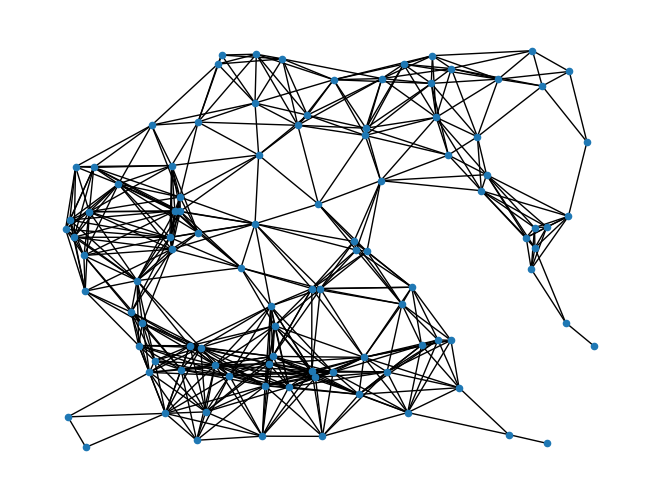

In [3]:
G, pos = create_graph(100)
nx.draw(G, pos=pos, node_size=20)

The exchange between communities happens in a number of cycles (time periods) indexed by $k=1,\dots N_t$. The population of community $i$ at the beginning and end of cycle $k$ is denoted as $u_i^{k-1}$ and $u_i^{k}$ respectively.

The model assumes that in each cycle the number of members that move from community $i$ to community $j$ can be expressed as a fraction $m_{ij}$ of the population of community $i$ *at the end of the cycle*, so $m_{ij} u_i^k$ is the number moving from $i$ to $j$. The same fraction $m_{ji}=m_{ij}$ of community $j$ moves to community $i$, thus $m_{ij} u_j^k = m_{ji} u_j^k$ organisms are moving from $j$ to $i$. You can think of $m_{ij}$ as the _likelihood_ of travelling between community $i$ and $j$ which might be determined by how easy it is to travel between the two locations.

Using the notation $\mathcal{N}_i$ for the set of neighbours of community $i$, we obtain the following population balance for community $i$:

\begin{align*}
  u^{k}_i &= u^{k-1}_i - \overbrace{\sum_{j\in\mathcal{N}_i} m_{ij} u_i^{k}}^{\text{moving away}} 
  + \overbrace{\sum_{j\in\mathcal{N}_i} m_{ij} u_j^{k}}^{\text{coming in}} \\
            &= u^{k-1}_i - \left(\left(\sum_{j\in\mathcal{N}_i} m_{ij}\right) u_i^{k} - \sum_{j\in\mathcal{N}_i} m_{ij} u_j^{k}\right) \\
\end{align*}

If we define a matrix $\underline{\bf A}$ such that

\begin{align*}
  \underline{\bf A}_{ii} &= \sum_{j\in\mathcal{N}_i} m_{ij} \\
  \underline{\bf A}_{ij} &= -m_{ij} & \text{ for }j\neq i, j \in \mathcal{N_i} \\
  \underline{\bf A}_{ij} &=0 & \text{ for }j\neq i, j \notin \mathcal{N_i}
\end{align*}

we can write the population equation compactly as

$$
  {\bf u}^{k} = {\bf u}^{k-1} - \underline{\bf A}{\bf u}^{k}
  \quad\text{ or }\quad
  \left(\underline{\bf I} + \underline{\bf A}\right) {\bf u}^{k} = {\bf u}^{k-1},
$$

where ${\bf u}^k$ is the vector of length $n$ given the population in each community at end of cycle $k$. The matrix $\underline{\bf A}$ depends on our choice of exchange coefficients $m_{ij}$. Each coefficient $m_{ij}=m_{ji}$ describes the exchange between communities $i$ and $j$ and can therefore be associated with an edge in the (undirected) graph. We will store these coefficients in a single vector $\bf m$ of length $N_e$, the number of edges (connected neighbours). To generate the matrix you may use the following code:

In [4]:
n = 100  # number of communities
G, pos = create_graph(n)

def generate_A_matrix(G, m):
    """Generate the exchange matrix A based on the exchange coefficients m"""
    nx.set_edge_attributes(G, dict(zip(G.edges, m)), name='weight')
    A = nx.laplacian_matrix(G)
    return A

N_e = G.number_of_edges()
m = np.random.uniform(0, 1, N_e)  # choose random weights in the [0, 1] interval
A = generate_A_matrix(G, m)

**3.1** Investigate the properties of matrix $\underline{\mathbf A}$ (any properties relevant for solving the linear system below) either from its mathematical definition, or in code by investigating the matrices produced by `generate_A_matrix` for a number of different graphs and choices of `m`. Based on your conclusions recommend an iterative solver for solving the system

$$\left(\underline{\bf I} + \underline{\bf A}\right) {\bf u}^{k+1} = {\bf u}^k$$

1. **Symmetry**: Since $m_{ij} = m_{ji}$, $\underline{\mathbf A}$ is symmetric. This is due to the edges in the undirected graph not having a direction, and the exchange coefficients are the same in both directions.

2. **Semi-definiteness**: Laplacian matrices are semi-definite. This means all its eigenvalues are non-negative.

3. **Sparsity**: In most community exchange models, each community only exchanges members with a few neighbors, meaning most elements in $\underline{\mathbf A}$ are zero, making the matrix sparse.

4. **Row Sum to Zero**: The sum of elements in each row of a Laplacian matrix is zero. This reflects the fact that the total population remains constant.

Based on these properties, to solve the equation

$$\left(\underline{\bf I} + \underline{\bf A}\right) {\bf u}^{k+1} = {\bf u}^k$$

we need an iterative solver that can efficiently handle sparse, symmetric, and semi-definite matrices.

The conjugate gradient method might be a good choice.
- **Conjugate Gradient (CG) Method**: For large sparse symmetric positive-definite matrices, the conjugate gradient method is very efficient. Although $\underline{\bf A}$ is semi-definite, $\underline{\bf I} + \underline{\bf A}$ is positive-definite. The unit matrix increases the value of the eigenvalues, making the matrix positive definite.

**3.2** Implement the model that for a given graph `G`, an initial population vector ${\bf u}^0$ and exhange coefficient vector ${\bf m}$, performs $N_t$ exhange cycles ("time steps"), and returns 
a list of arrays representing the population vectors ${\bf u}^k, k=1,\dots N_t$, the solutions at the end of each cycle. You may use linear solvers from `scipy` here and in the rest of Q3. Demonstrate your model by choosing a random initial population vector, a random exhange-coefficient vector with $0\leq m_{ij}\leq 1$ and $N_t=5$ and plotting the initial and final population vector. For the plotting you may use the code below. Try out different values of $N_t$ and describe your observations.

In [5]:
import scipy
from scipy.sparse import csr_matrix
import scipy.sparse.linalg

def model(G, u0, m, N_t):
    n = len(G)
    edges = list(G.edges())
    A_data = []
    A_rows = []
    A_cols = []
    
    # Map edges to their weights
    edge_weight_map = {edge: weight for edge, weight in zip(edges, m)}
    
    for i, j in edges:
        weight = edge_weight_map[(i, j)]
        A_data.extend([-weight, -weight])
        A_rows.extend([i, j])
        A_cols.extend([j, i])
    
    # Add diagonal elements
    for i in range(n):
        A_data.append(-sum(A_data[k] for k in range(len(A_data)) if A_rows[k] == i))
        A_rows.append(i)
        A_cols.append(i)
    
    A = csr_matrix((A_data, (A_rows, A_cols)), shape=(n, n))
    I = csr_matrix(np.eye(n))
    
    u_list = [u0]
    for _ in range(N_t):
        u_next = scipy.sparse.linalg.spsolve(I + A, u_list[-1])
        u_list.append(u_next)
    
    return u_list


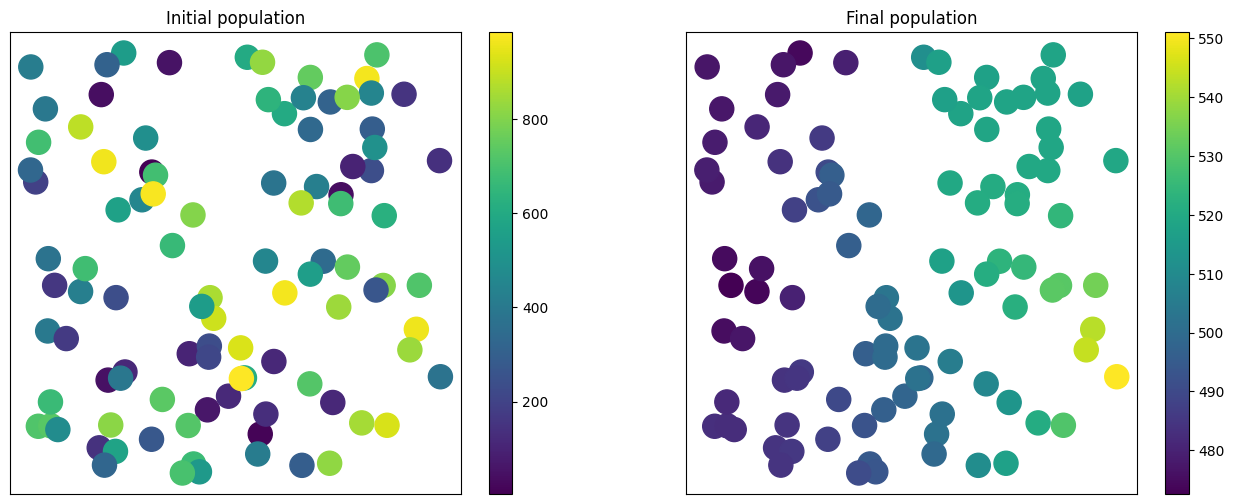

In [6]:
# Use the predefined graph G and position pos
n = len(G.nodes())  # Get the number of nodes
N_e = len(G.edges())  # Get the number of edges

m = np.random.uniform(0, 1, N_e)  # choose random weights in the [0, 1] interval
u0 = np.random.uniform(0, 1000, n)  # choose random initial population in [0, 1000] (your choice really)

# Set the number of exchange cycles N_t
N_t = 5

u_list = model(G, u0, m, N_t)
u_Nt = u_list[-1]  # taking the last solution vector

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(16, 6))
c = nx.draw_networkx_nodes(G, pos=pos, node_color=u0, ax=ax[0])
ax[0].set_title('Initial population')
fig.colorbar(c, ax=ax[0])
c = nx.draw_networkx_nodes(G, pos=pos, node_color=u_Nt, ax=ax[1])
ax[1].set_title('Final population')
fig.colorbar(c, ax=ax[1]);

**Conclusion:** 

From the figure, changes can be observed between the initial population distribution (left panel) and the final population distribution after five exchange cycles (right panel). These changes reflect the migration and distributional adjustments of the population between the different communities.

Exchange coefficient $m_{ij}$affects the intensity of population exchanges between communities, leading to different patterns in the final population distribution.

By trying different values of $N_t$, we can observe the evolution of the population distribution over time. Smaller values of $N_t$ may not be sufficient to show significant changes in the population distribution, while larger values of $N_t$ can cause the population distribution to equalize or demonstrate more complex patterns of dynamic change.

**Note:** We used randomly generated initial population vectors and exchange coefficient vectors, and the results may vary each time the model is run.

We will examine a scenario where we have observations of population numbers ${\bf u}^k$ for a number of cycles, labeled ${\bf u}_{\text{obs}}^k, k=1, \dots N_t$ and also know the initial population ${\bf u}^0$. We also know the graph for this scenaro, in other words which communities are connected to what other communities, but we don't know the exchange coefficients ${\bf m}$. In order for us to invert for these coefficients we formulate the problem as a constrained optimisation problem:

$$
\text{minimize } f({\bf u}, {\bf m}) = \sum_{i=1}^{N_t} \tfrac 12\| {\bf u}_{\text{obs}}^i - {\bf u}^i \|^2
$$


subject to the _discrete_ constraint

$$
\newcommand\bigm{\underline{\mathbf I} + \underline{\mathbf A}}
\newcommand\idt{\underline{\mathbf I}}
{\bf g}({\bf u}, {\bf m}) =
\begin{pmatrix}
\bigm & 0 & 0 &  \dots & 0 & 0 & 0  \\
-\idt & \bigm &  0 & \dots & 0 & 0  & 0 \\
0 & -\idt & \bigm & \ddots & 0 & 0  & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots & \vdots & \vdots \\
0 &  0 & 0 & \ddots & \bigm & 0 & 0 \\
0 & 0 &  0 & \ddots & -\idt & \bigm & 0 \\
0 & 0 &  0 & \dots & 0 & -\idt & \bigm 
\end{pmatrix}
\begin{pmatrix}
  \vphantom\bigm {\bf u}^1 \\ \vphantom\bigm{\bf u}^2 \\ \vphantom\bigm{\bf u}^3 \\ \vphantom\bigm\vdots \\ \vphantom\bigm{\bf u}^{N_t-2} \\ \vphantom\bigm{\bf u}^{N_t-1} \\ \vphantom\bigm{\bf u}^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  {\bf u}^0 \\ \vphantom\bigm {\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm\vdots \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0}
\end{pmatrix} = 0
$$

Note that although there is no continuous PDE involved here, you can treat the optimisation problem exactly as the discontinuous case of a PDE-constrained optimisation problem.

**4.3** Write down the Lagrangian $L({\bf u}, {\bf m}, \boldsymbol\lambda)$ for this constrained optimisation problem, and describe how the 
Lagrange multipliers (adjoint solution) $\boldsymbol{\lambda}^{1}\dots \boldsymbol{\lambda}^{N_t}$ can be solved one-by-one for given ${\bf m}$ and $\bf u$  where $\bf u$ represents the entire forward solution composed of solution vectors ${\bf u}^k$ for each cycle $k$. Work out the equations in terms of the observation vectors ${\bf u}_{obs}^k$ and solution vectors ${\bf u}^k$.

**The Lagrangian $L({\bf u}, {\bf m}, \boldsymbol\lambda)$.**

Incorporates the original objective function $f({\bf u}, {\bf m})$ along with the product of the constraints ${\bf g}({\bf u}, {\bf m}) = 0$ and the Lagrange multipliers $\boldsymbol\lambda$. 

$$
L({\bf u}, {\bf m}, \boldsymbol\lambda) = \sum_{i=1}^{N_t} \frac{1}{2}\| {\bf u}_{\text{obs}}^i - {\bf u}^i \|^2 + \sum_{k=1}^{N_t} \boldsymbol\lambda^{k} \cdot \left(\left(\underline{\mathbf I} + \underline{\mathbf A}({\bf m})\right) {\bf u}^{k} - {\bf u}^{k-1}\right)
$$

where ${\bf u}_{\text{obs}}^i$ is the observed population vector for cycle $i$, ${\bf u}^i$ is the corresponding model solution vector, and $\boldsymbol\lambda^{k}$ is the vector of Lagrange multipliers (adjoint solution) for cycle $k$.

**Solving for the Lagrange Multipliers (Adjoint Solution).**

The Lagrange multipliers $\boldsymbol{\lambda}^{1}\dots \boldsymbol{\lambda}^{N_t}$ can be solved sequentially by:

1. Starting from the last cycle $N_t$, and using the observed values ${\bf u}_{\text{obs}}^k$ and solution vectors ${\bf u}^k$ to compute $\boldsymbol\lambda^{N_t}$.
2. Then, iteratively moving backwards through each cycle $k = N_t-1, N_t-2, ..., 1$, using $\boldsymbol\lambda^{k+1}$ and ${\bf u}^k$ to compute $\boldsymbol\lambda^k$.

For each cycle $k$, the adjoint equation can be represented as:

$$
\left(\underline{\mathbf I} + \underline{\mathbf A}({\bf m})\right)^T \boldsymbol\lambda^{k} = \boldsymbol\lambda^{k+1} + {\bf u}^k - {\bf u}_{\text{obs}}^k
$$

where $\left(\underline{\mathbf I} + \underline{\mathbf A}({\bf m})\right)^T$ is the transpose matrix, indicating the need to transpose the forward model matrix when computing the adjoint solution.

**Calculating$\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$, the derivative of the objective function.**

Once we have the forward solution $\bf $ and the adjoint solution $\boldsymbol\lambda$, we can calculate the derivative of $\hat{f}({\bf m})$. 

This derivative can be calculated as follows:

$$
\frac{\partial\hat{f}({\bf m})}{\partial{\bf m}} = \sum_{k=1}^{N_t} \left( \frac{\partial{\bf g}^k({\bf u}, {\bf m})}{\partial{\bf m}} \right)^T \boldsymbol\lambda^{k}
$$

where $\frac{\partial{\bf g}^k({\bf u}, {\bf m})}{\partial{\bf m}}$ is the derivative of the constraint ${\bf g}^k$ with respect to ${\bf m}$, which can be computed using the function 'dgdm'.

As in lecture 11, we also define the associated reduced functional

$$\hat{f}({\bf m}) = f({\bf u}({\bf m}), {\bf m}),
\text{ where }{\bf u}({\bf m}) = {\bf u}
\text{ is the solution to }{\bf g}({\bf u}, {\bf m}) = 0,
$$

in other words we run the forward model using ${\bf m}$ to compute ${\bf u}$, and using these values compute $f$.

In that lecture 11 it is explained how its derivative $\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$ can be calculated from the forward solution
$\bf u$, and the adjoint solution $\boldsymbol\lambda$. The calculation involves the derivative $\frac{\partial{\bf g}({\bf u}, {\bf m})}{\partial{\bf m}}$. Let

$$
  {\bf g}^k({\bf u}, {\bf m}) = \left(\underline{\mathbf I} + \underline{\mathbf A}({\bf m})\right) {\bf u}^{k} - {\bf u}^{k-1}
$$

represent the constraint associated with cycle $1\leq k\leq N_t$. ${\bf g}^k$ represents $n$ out of the $N_t\cdot n$ equations of the complete constraint $\bf g({\bf u}, {\bf m})=0$. Its derivative

$$
  \frac{\partial{\bf g}^k({\bf u}, {\bf m})}{\partial{\bf m}} 
  = \frac{\partial \underline{\mathbf A}({\bf m}){\bf u}^{k+1}}{\partial{\bf m}}
$$

is a $n \times N_e$ matrix and can be computed using the following code:

In [7]:
import scipy.sparse as sp
import scipy.sparse.linalg as spl

def dgdm(G, uk):
    """Compute dg/dm for cycle k

    uk is the u^k solution vector at the end of cycle k."""
    inc = nx.incidence_matrix(G, oriented=True)
    du = inc.T @ uk
    nx.set_edge_attributes(G, dict(zip(G.edges, du)), name='du')
    winc = nx.incidence_matrix(G, weight='du', oriented=True)
    return winc

Note that although ${\bf g}^k$ depends on $\bf u$ and $\bf m$, its derivative $\partial{\bf g}^k/\partial{\bf m}$ no longer explicitly depends on $\bf m$, but only on $\bf u^{k}$ (and the graph). You do not need to understand how this code calculates the derivative and can just use it as is.

Finally, you can generate the observations by choosing a random vector $\bf m_{\text{target}}$ of exchange coefficients, choosing a random initial population vector ${\bf u}^0$
and creating "synthetic" observations by using $\bf m_{\text{target}}$ and ${\bf u}^0$ to run your forward model once
and storing the solution vectors ${\bf u}^k$ as the observations. Below are the suggested values for this experiment

In [8]:
# NOTE: you only need to consider a small population model
# you will notice that for larger values of n the inversion
# problem may not be very robust
n = 10
N_t = 5  # suggested number of cycles

G, pos = create_graph(n)
N_e = G.number_of_edges()
m_target = np.random.uniform(0, 1, N_e)
u0 = np.random.uniform(0, 1000, n)
u_obs = model(G, u0, m_target, N_t)

Note that you should use this same `u0` as the initial condition in your inversion experiment, and use `u_obs` as the given observations. `m_target` however will be the unknown vector of exchange coefficients that we will use for validation afterwards, so should not appear in your forward or adjoint models.

In [9]:
def solve_adjoints(G, u, u_obs, m, N_t, cg_tol=1e-5):
    # Initialize list for adjoint solutions
    lambda_list = [None for _ in range(N_t)]
    A = generate_A_matrix(G, m)
    
    # Create the identity matrix
    I = sp.eye(A.shape[0], format='csr')
    I_plus_A = I + A
    I_plus_A_T = I_plus_A.transpose()

    # Use observation errors to compute the adjoint solution for the last timestep
    rhs = u[-1] - u_obs[-1]
    lambda_list[-1] = rhs  # Adjoints for the last timestep

    # Backward iteration to compute adjoint solutions for other timesteps
    for k in range(N_t-2, -1, -1):
        # Use Conjugate Gradient method to solve the adjoint equation
        lambda_k_plus_1 = lambda_list[k+1]
        rhs = lambda_k_plus_1 - (u[k] - u_obs[k])
        lambda_k, info = spl.cg(I_plus_A_T, rhs, tol=cg_tol)
        
        if info != 0:
            raise ValueError(f"CG did not converge at step {k}")
        lambda_list[k] = lambda_k

    return lambda_list

**4.4** Implement the python functions `fhat(m)` and `dfhatdm(m)` that take in the `m`-vector and return respectively
$\hat{f}({\bf m})$ (a float), and $\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$ (as an array). Test your derivative for correctness. Hint: in your tests, you may need to look at the tolerances you specify when using iterative solvers in your model.

In [10]:
def fhat(m):
    # Run the forward model to obtain u
    u = model(G, u0, m, N_t)
    # Calculate the objective function value
    f_val = sum(0.5 * np.linalg.norm(u_obs[k] - u[k])**2 for k in range(N_t))
    return f_val


In [11]:
def dfhatdm(m):
    # Run the forward model to obtain solution vectors u for each time step
    u = model(G, u0, m, N_t)
    # Initialize the derivative vector
    dfdm = np.zeros_like(m)
    # Compute the adjoint solutions
    lambda_k = solve_adjoints(G, u, u_obs, m, N_t)  
    
    # For each time step, compute the derivative using dgdm
    for k in range(1, N_t+1):  
        winc = dgdm(G, u[k-1]) 
        dfdm += winc.T.dot(lambda_k[k-1])  
    return dfdm

We use Taylor's test to verify the correctness of our implemented function.

In [12]:
import scipy.linalg as sl
# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

def taylor_test(f, grad_f, x, h0, max_iter=8, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    fx = f(x)
    dfdx = grad_f(x)
    
    for i in range(max_iter):
        if len(h.shape)>1:
            # tensordot sums over all indices of h and corresponding last indices of dfdx
            r = f(x + h) - fx - np.tensordot(dfdx, h, axes=len(h.shape))
        else:
            r = f(x + h) - fx - dfdx @ h
            
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

In [13]:
# Assuming that m0 is a suitable starting point
m0 = np.random.uniform(0, 1, N_e) 
h0 = np.random.uniform(-0.1, 0.1, N_e)  

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[0.62872358 0.86259558 0.93960947 0.97157554 0.98619847 0.99319824
 0.99662343]


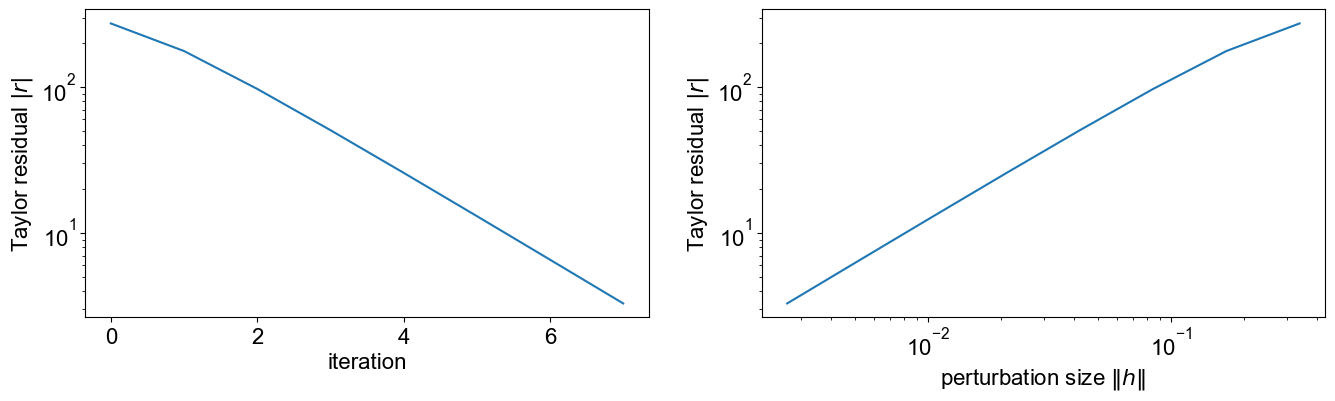

In [14]:
taylor_test(fhat, dfhatdm, m0, h0, max_iter=8, plot_convergence=True, print_convergence=True)

The residual converges which indicates a correct implementation.

**4.5** Now perform the inversion experiment. For this you may use the following configuration of the L-BFGS-B minimisation algorithm implemented in scipy:

In [15]:
import scipy.optimize as sop

m0 = np.random.uniform(0, 1, N_e)  # random initial guess for m
result = sop.minimize(fhat, m0, jac=dfhatdm, options={'maxiter':1000, 'gtol': 1e-6, 'maxcor': 100}, method='l-bfgs-b')
print(result)  # always check the output!

minv = result['x']  # the optimised exchange coefficients

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2742393949260447
        x: [ 6.326e-01  3.349e-01 ...  3.659e-01  8.796e-01]
      nit: 29
      jac: [-2.411e+00 -1.066e+01 ... -2.578e+00  4.301e+00]
     nfev: 58
     njev: 58
 hess_inv: <32x32 LbfgsInvHessProduct with dtype=float64>


Evaluate the success of your experiment by comparing the solution `minv` with `m_target`, and by comparing the forward solution vectors ${\bf u}^k$, if you rerun the forward model with `minv` and the same initial condition as before, with the observations. Also construct a different initial solution, and compare the output of your forward model when run with `minv`, when run with `m_target`, and when run with a new, completely unrelated random vector `m`. Draw some conclusions about the predictive power of the forward model using the inverted exchange coefficients `minv` - has the predictive skill of the forward model improved by the inversion? Discuss how the inversion might be improved in the presence of more observational data.

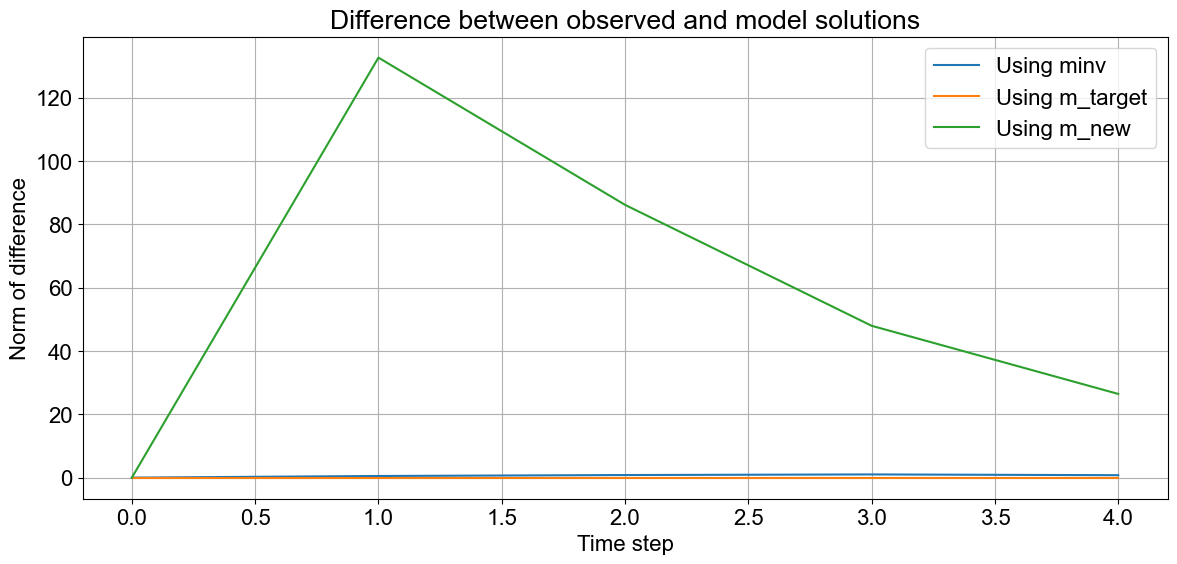

In [16]:
# Running a forward model with minv
u_minv = model(G, u0, minv, N_t)

# Run the forward model with m_target
u_target = model(G, u0, m_target, N_t)

# Run the forward model with a new random vector m
m_new = np.random.uniform(0, 1, N_e)
u_new = model(G, u0, m_new, N_t)

def compare_solutions(u_obs, u_models, titles):
    plt.figure(figsize=(14, 6))
    
    for u_model, title in zip(u_models, titles):
        diffs = [np.linalg.norm(u_obs[k] - u_model[k]) for k in range(N_t)]
        plt.plot(range(N_t), diffs, label=title)
    
    plt.xlabel('Time step')
    plt.ylabel('Norm of difference')
    plt.title('Difference between observed and model solutions')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_solutions(u_obs, [u_minv, u_target, u_new], ['Using minv', 'Using m_target', 'Using m_new'])


Each line represents the use of a different exchange coefficient vector 'm', and by comparing these lines we can visualize the impact of different exchange coefficient vectors on the accuracy of model predictions. The solution obtained using **'minv'** is much closer to the observed data **'u_obs(m_target)'**, suggesting that the inversion was successful in identifying exchange coefficients that would improve the model predictions.